**Conexão com Drive**

In [100]:
from google.colab import drive
drive.mount('/content/drive')
#drive.mount('/content/drive', force_remount=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Importar base de dados**

In [101]:
!unzip -uq "/content/drive/My Drive/FruitsDB_2" -d "/content"

In [102]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import pandas as pd

from skimage.color import rgb2gray
from skimage.transform import rescale, resize, downscale_local_mean

from sklearn.model_selection import train_test_split
from skimage import data, color, feature
from skimage.feature import hog

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

import glob

from random import seed
from random import randint

**Salvar em array as imagens e labels**

In [103]:
def load_data(fruit, tipo):
    label=[]
    arr = []
    strr = "FruitsDB_2/"+fruit+"/" + tipo + "/*"
    for file_ in glob.glob(strr):
      img = cv2.imread(file_)
      arr.append(img)
      label.append(fruit)
   
    return arr,label

In [104]:
def whole_train_data(tipo):
  apples_data, apples_label = load_data('Apples', tipo)
  mangoes_data, mangoes_label = load_data('Mangoes', tipo)
  oranges_data, oranges_label = load_data('Oranges', tipo)
  data =np.concatenate((apples_data,mangoes_data,oranges_data))
  labels =np.concatenate((apples_label, mangoes_label, oranges_label))
  return data, labels

**Holdout**

In [105]:
data_train, labels_train = whole_train_data('Train')
data_test, labels_test = whole_train_data('Test')

**Visualizar formato dos dados**

In [106]:
data_train.shape, labels_train.shape

((1461, 100, 100, 3), (1461,))

**Preprocessamento 1 (conversão em grayscale e redimensionamento) dos dados**

In [107]:
def preprocessing(arr):
    arr_prep=[]
    for i in range(arr.shape[0]):
        img = cv2.cvtColor(arr[i], cv2.COLOR_BGR2GRAY)
        img=resize(img, (72, 72),anti_aliasing=True)
        arr_prep.append(img)
    return arr_prep

In [108]:
data_train_p = preprocessing(data_train)
data_test_p = preprocessing(data_test)

**Extrair HOG (Histogram of Oriented Gradients) dos dados**

In [109]:
def ExtractHOG(img):
    ftr,_=hog(img, orientations=8, pixels_per_cell=(16, 16),
            cells_per_block=(1, 1), visualize=True, multichannel=False)
    return ftr
  
def preprocessing_part_two(arr):
    arr_feature=[]
    for i in range(np.shape(arr)[0]):
        arr_feature.append(ExtractHOG(arr[i])) 
    return arr_feature

In [110]:
data_train_ftr = preprocessing_part_two(data_train_p)
data_test_ftr= preprocessing_part_two(data_test_p)

**KNN para classificação**

In [111]:
knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=8)
knn_clf.fit(data_train_ftr, labels_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=8, p=2,
                     weights='distance')

In [112]:
y_knn_pred = knn_clf.predict(data_test_ftr)

In [113]:
print(accuracy_score(labels_test, y_knn_pred)*100,'%')

95.91836734693877 %


**Validação Cruzada**

In [114]:
accuracy_arr = []
for i in range(1,50):
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(data_train_ftr, labels_train)
  y_knn_pred = knn.predict(data_test_ftr)
  accuracy = accuracy_score(labels_test, y_knn_pred)
  accuracy_arr.append(accuracy)
  i += 1
best_k_percent = max(accuracy_arr) 
best_k = accuracy_arr.index(best_k_percent) + 1
print("Best K equals to {}, accuracy of {:.2f}%".format(best_k, best_k_percent * 100))

Best K equals to 8, accuracy of 97.14%


**Plotar imagens**

In [115]:
def showImg(img, name):
    plt.axis("off")
    plt.title(name)
    plt.imshow(img)
    plt.show()

**Teste**

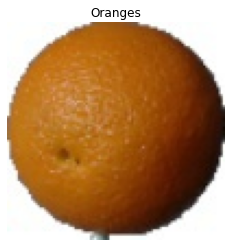

In [119]:
x_ = randint(0, data_test.shape[0])
datatest_img = cv2.cvtColor(data_test[x_], cv2.COLOR_BGR2RGB)
showImg(datatest_img, y_knn_pred[x_])